In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
from itertools import product
import torch

# One dimension

In [3]:
data = stats.norm.rvs(10, 30, 1000)

data.shape

(1000,)

In [6]:
normal_with_var = cp.NormalKnownVar(30, [0, 1])

normal_with_var.find_predictive_posterior(data)

print(normal_with_var.prior_params)
print(normal_with_var.posterior_params)
print(normal_with_var.posterior_predictive_params)

mean, sigma = normal_with_var.posterior_predictive_params.mu, normal_with_var.posterior_predictive_params.sigma

namespace(mu=0, sigma=1)
namespace(mu=9.55590778971325, sigma=0.029126213592233007)
namespace(mu=9.55590778971325, sigma=30.02912621359223)


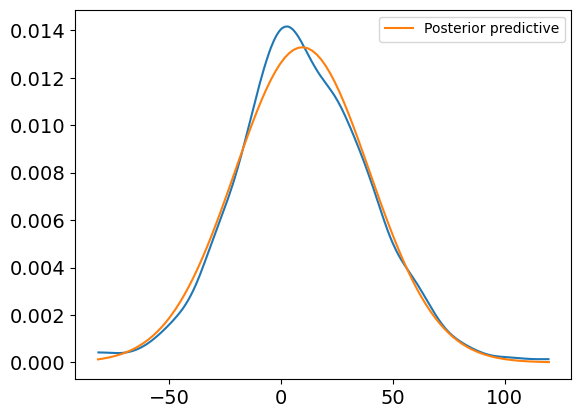

In [8]:
fig, ax = plt.subplots()

az.plot_kde(data, ax = ax)
x = np.linspace(data.min(), data.max(), 100)
ax.plot(x, stats.norm.pdf(x, mean, sigma), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

In [4]:
normal_with_mean = cp.NormalKnownMean(5, [0, 1], data)

print(normal_with_mean.prior_params)
print(normal_with_mean.posterior_params)
print(normal_with_mean.posterior_predictive_params)

df = normal_with_mean.posterior_predictive_params["nu"]
loc = normal_with_mean.posterior_predictive_params["loc"]
scale = normal_with_mean.posterior_predictive_params["scale"]

{'alpha': 0, 'beta': 1}
{'alpha': 500.0, 'beta': 481510.18653784785}
{'k': 500.0, 'loc': 5, 'scale': 31.03256955322417}


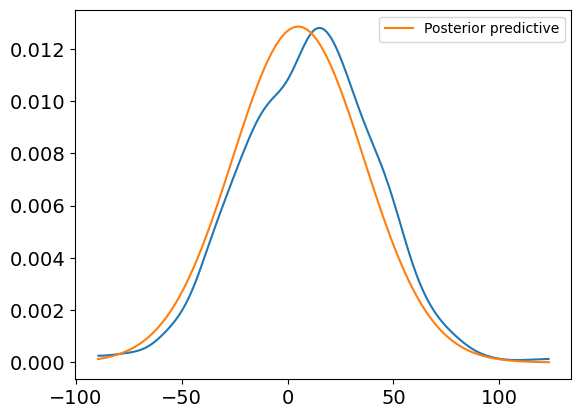

In [5]:
fig, ax = plt.subplots()

az.plot_kde(data, ax = ax)
x = np.linspace(data.min(), data.max(), 100)
ax.plot(x, stats.t.pdf(x, df, loc, scale), color = "C1", label = "Posterior predictive")
ax.legend()
plt.show();

# Multi-dimensional

In [18]:
mv_data = stats.multivariate_normal.rvs([3, 6], [[1, 0.5],[0.5, 1]], size = (10,))

In [4]:
mv_normal_known_cov = cp.MvNormalKnownCov(
    np.array([[1, 0.5], [0.5, 1]]),
    [
        [0, 0],
        np.array([[1, 0], [0, 1]])
    ],
    mv_data
)

prior_mean, prior_cov = [
        [0, 0],
        np.array([[1, 0], [0, 1]])
    ]
post_mean, post_cov = mv_normal_known_cov.posterior_predictive_params["mean"], mv_normal_known_cov.posterior_predictive_params["covariance"]

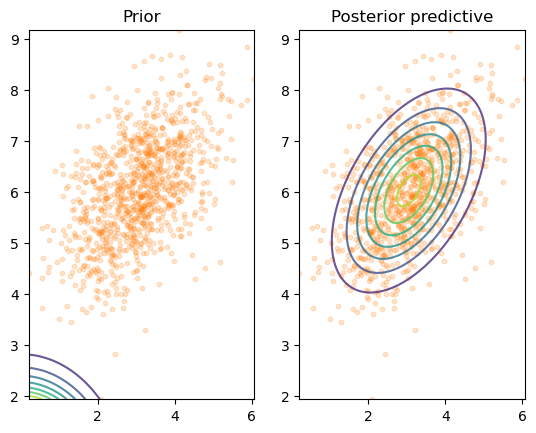

In [5]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(mv_data[:, 0].min(), mv_data[:, 0].max(), 100)
z2 = np.linspace(mv_data[:, 1].min(), mv_data[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_normal.pdf(pos, mean = prior_mean, cov = prior_cov), alpha = 0.8)
ax[1].contour(x, y, stats.multivariate_normal.pdf(pos, mean = post_mean, cov = post_cov), alpha = 0.8)
ax[0].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 0.2, color = "C1")
ax[1].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 0.2, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

In [21]:
mv_data = stats.multivariate_normal.rvs([3, 6], [[1, 0.5],[0.5, 1]], size = (2,))

In [35]:
mv_data.mean(axis = 1)

array([5.88207594, 4.16087419])

In [36]:
mv_normal_known_mean = cp.MvNormalKnownMean(
    mv_data.mean(axis = 0),
    [
        3,
        np.array([[2, 2], [2, 2]])
    ],
    mv_data
)

mean = mv_data.mean(axis = 0)
prior_df, prior_scale = [3, np.array([[1, 0], [0, 1]])]
post_df, post_loc, post_scale = mv_normal_known_mean.posterior_predictive_params["df"], mv_normal_known_mean.posterior_predictive_params["loc"], mv_normal_known_mean.posterior_predictive_params["scale"]

print(mv_normal_known_mean.prior_params)
print(mv_normal_known_mean.posterior_params)
print(mv_normal_known_mean.posterior_predictive_params)

{'df': 3, 'scale': array([[2, 2],
       [2, 2]])}
{'df': 5, 'scale': array([[2., 2.],
       [2., 2.]])}
{'df': 4, 'loc': array([3.5222885 , 6.52066162]), 'scale': array([[0.5, 0.5],
       [0.5, 0.5]])}


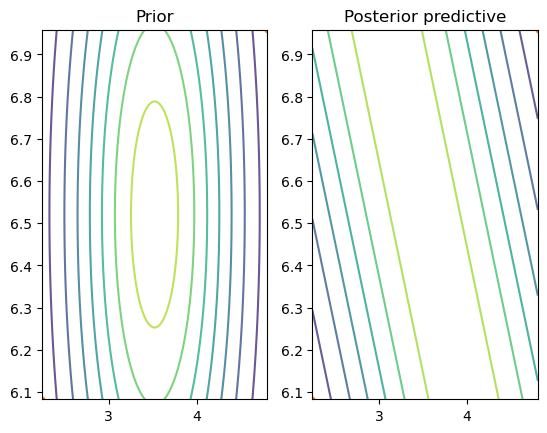

In [39]:
fig, ax = plt.subplots(ncols = 2)

z1 = np.linspace(mv_data[:, 0].min(), mv_data[:, 0].max(), 100)
z2 = np.linspace(mv_data[:, 1].min(), mv_data[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax[0].contour(x, y, stats.multivariate_t.pdf(pos, loc = mean, shape = prior_scale, df = prior_df), alpha = 0.8)
ax[1].contour(x, y, stats.multivariate_t.pdf(pos, loc = post_loc, shape = post_scale, df = post_df, allow_singular = True), alpha = 0.8)
ax[0].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 1, color = "C1")
ax[1].scatter(mv_data[:, 0], mv_data[:, 1], 10, alpha = 1, color = "C1")

ax[0].set_title("Prior")
ax[1].set_title("Posterior predictive")

plt.show();

# DDKS Distance Checks

## Visualising

In [7]:
samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)

analytic_cdf = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf(samples)

In [8]:
samples.sort()
analytic_cdf.sort()

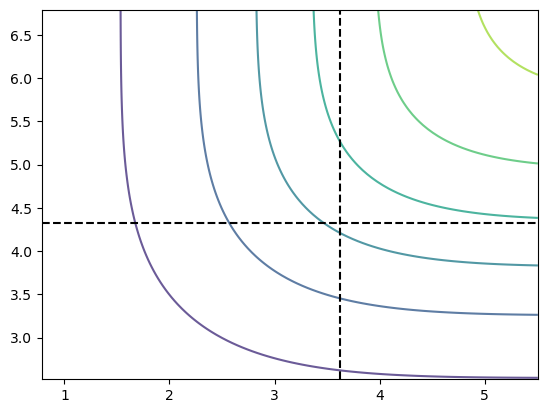

[[False False]
 [False  True]
 [ True False]
 [ True  True]] [29 38  4 29]


In [11]:
test_idx = np.random.randint(0, high = samples.shape[0])
test_point = samples[test_idx]

fig, ax = plt.subplots()

x = samples[:, 0]
y = samples[:, 1]

z1 = np.linspace(samples[:, 0].min(), samples[:, 0].max(), 100)
z2 = np.linspace(samples[:, 1].min(), samples[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

ax.contour(x, y, stats.multivariate_normal.cdf(pos, mean = [3, 4], cov = [[2, 1], [1, 2]]), alpha = 0.8)
#ax.scatter(samples[:, 0], samples[:, 1], 10, alpha = 0.2, color = "C1")

ax.vlines(test_point[0], ymin = y.min(), ymax = y.max(), linestyle = "--", color = "black")
ax.hlines(test_point[1], xmin = x.min(), xmax = x.max(), linestyle = "--", color = "black")

plt.show();

mask = samples >= test_point

unique, counts = np.unique(mask, return_counts=True, axis = 0)

print(unique, counts)

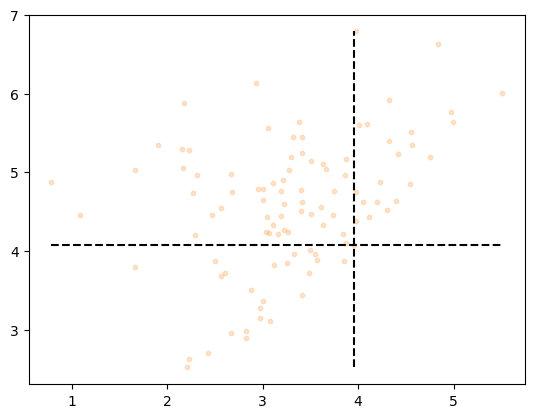

[[False False]
 [False  True]
 [ True  True]] [24 53 23]


In [12]:
test_idx = np.random.randint(0, high = samples.shape[0])
test_point = samples[test_idx]

fig, ax = plt.subplots()

x = samples[:, 0]
y = samples[:, 1]

z1 = np.linspace(samples[:, 0].min(), samples[:, 0].max(), 100)
z2 = np.linspace(samples[:, 1].min(), samples[:, 1].max(), 100)
x, y = np.meshgrid(z1, z2)
pos = np.dstack((x, y))

#ax.contour(x, y, stats.multivariate_normal.cdf(pos, mean = [3, 4], cov = [[2, 1], [1, 2]]), alpha = 0.8)
ax.scatter(samples[:, 0], samples[:, 1], 10, alpha = 0.2, color = "C1")

ax.vlines(test_point[0], ymin = y.min(), ymax = y.max(), linestyle = "--", color = "black")
ax.hlines(test_point[1], xmin = x.min(), xmax = x.max(), linestyle = "--", color = "black")

plt.show();

mask = samples >= test_point

unique, counts = np.unique(mask, return_counts=True, axis = 0)

print(unique, counts)

In [79]:
import torch

samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)
samples = torch.Tensor(samples)

samples = samples.unsqueeze(-1)

samples = samples.repeat((1, 1, 100))

In [80]:
points = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(100)
points = torch.Tensor(points)

points = points.unsqueeze(-1)

points = points.repeat((1, 1, 100))

points = points.permute((2,1,0))

In [94]:
torch.ge(samples, points).long()[:, 0, :]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [86]:
float(samples[0, 0, 1] < 0)

0.0

In [95]:
samples

tensor([[[3.8536, 3.8536, 3.8536,  ..., 3.8536, 3.8536, 3.8536],
         [3.9090, 3.9090, 3.9090,  ..., 3.9090, 3.9090, 3.9090]],

        [[3.5105, 3.5105, 3.5105,  ..., 3.5105, 3.5105, 3.5105],
         [3.8780, 3.8780, 3.8780,  ..., 3.8780, 3.8780, 3.8780]],

        [[4.3651, 4.3651, 4.3651,  ..., 4.3651, 4.3651, 4.3651],
         [3.0475, 3.0475, 3.0475,  ..., 3.0475, 3.0475, 3.0475]],

        ...,

        [[4.3333, 4.3333, 4.3333,  ..., 4.3333, 4.3333, 4.3333],
         [5.3430, 5.3430, 5.3430,  ..., 5.3430, 5.3430, 5.3430]],

        [[3.2493, 3.2493, 3.2493,  ..., 3.2493, 3.2493, 3.2493],
         [4.5276, 4.5276, 4.5276,  ..., 4.5276, 4.5276, 4.5276]],

        [[3.4581, 3.4581, 3.4581,  ..., 3.4581, 3.4581, 3.4581],
         [6.0513, 6.0513, 6.0513,  ..., 6.0513, 6.0513, 6.0513]]])

## CDF development

### One sample development

In [334]:
samples = stats.multivariate_normal([4,4], [[1,0],[0,1]]).rvs(1)
samples = torch.Tensor(samples).unsqueeze(0)

In [335]:
F_sample = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf(samples)

F_max = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[10,10]])

F_ymax = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[samples[0,0],10]])

F_xmax = stats.multivariate_normal([3, 4], [[2, 1], [1, 2]]).cdf([[10,samples[0,1]]])

o1 = F_ymax - F_sample
o2 = F_max - F_ymax - F_xmax + F_sample
o3 = F_sample
o4 = F_xmax - F_sample


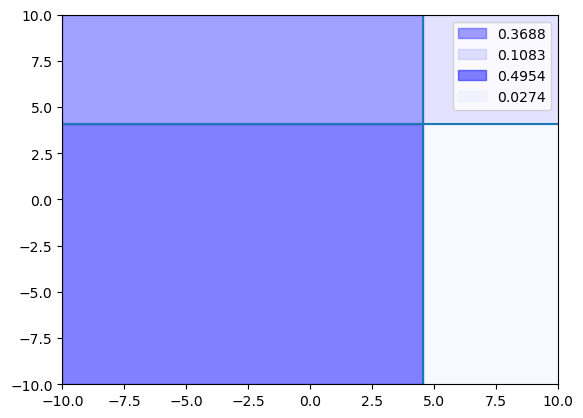

In [336]:
fig, ax = plt.subplots()

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.axvline(samples[0, 0])
ax.axhline(samples[0, 1])

ax.fill_between([-10, samples[0, 0]],samples[0, 1], 10, alpha = o1, label = round(o1, 4), color = "blue")
ax.fill_between([samples[0, 0], 10], samples[0, 1], 10, alpha = o2, label = round(o2, 4), color = "blue")
ax.fill_between([-10, samples[0, 0]], -10, samples[0, 1], alpha = o3, label = round(o3, 4), color = "blue")
ax.fill_between([samples[0, 0], 10], -10, samples[0, 1], alpha = o4, label = round(o4, 4), color = "blue")

ax.legend()

plt.show();

### Multi-sample

In [7]:
samples = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]]).rvs(2)
samples = samples.tolist()

In [5]:
def generate_combinations(list1, list2):
    # Combine the two lists into a list of tuples
    combined = list(zip(list1, list2))
    
    # Use itertools.product to get all combinations
    result = list(product(*combined))
    
    return result

def cdf_coordinates(points, max_value):
    
    d = len(points[0])
    N = len(points)

    max_value = [[max_value]*d]*N

    return list(map(generate_combinations, points, max_value))
    
def compare_m_terms(m_term, m_terms):
    
    out_terms = [[0] * len(m_term)]

    max_count = m_term.tolist().count(1)


    for term in m_terms:
        for i, j in enumerate(zip(term, m_term)):
            j, k = j
            try:
                if max_count ==  term.tolist().count(1):
                    break
            except:
                pass

            if (j != k) and (j == 1):
                break

            if i == len(term) - 1:
                out_terms.append(term.tolist())

    return out_terms

def get_orthant_density(coordinates, dist = None):    

    max_value = max([max(e) for e in coordinates])
    print(max_value)
    d = len(coordinates[0])
    n_orthants = int(np.power(2, d))

    densities = dist.cdf(coordinates)
    densities = {point: density for point, density in zip(coordinates, densities)}
    
    orthant_densities = []

    m_count = 0
    scoped_points = list(filter(lambda x: x.count(max_value) == m_count, coordinates))
    scoped_densities = [((np.array(point) == max_value).astype(int), density) for point, density in densities.items() if point in scoped_points]

    while len(orthant_densities) < n_orthants:

        while scoped_densities:
            m_term, current_density = scoped_densities.pop()

            if m_count == 0:
                orthant_densities.append((m_term, current_density))
            else:
                m_terms = np.array([m[0] for m in orthant_densities])
                relevant_terms = compare_m_terms(m_term, m_terms)
                relevant_densities = [density for m, density in orthant_densities if m.tolist() in relevant_terms]
                orthant_density = current_density - (sum(relevant_densities))
                orthant_densities.append((m_term, orthant_density))

        m_count += 1
        scoped_points = list(filter(lambda x: x.count(max_value) == m_count, coordinates))
        scoped_densities = [((np.array(point) == max_value).astype(int), density)  for point, density in densities.items() if point in scoped_points]

    return orthant_densities

def sort_orthants(densities):
    orthants = [i[0].tolist() for i in densities]
    orthants.sort(reverse=True)
    sorted_orthants = []
    print(orthants)
    for orth in orthants:
        orth = orth[::-1]
        density = [e[1] for e in densities if e[0].tolist() == orth][0]
        sorted_orthants.append(density)

    return torch.Tensor(sorted_orthants)

In [36]:
dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
samples = dist.rvs(2)

coordinates = cdf_coordinates(samples, 10)[0]

unsorted_densities = get_orthant_density(coordinates, stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
print(unsorted_densities)

densities = sort_orthants(unsorted_densities)

print(densities)

[(array([0, 0, 0]), 0.015885706205135568), (array([1, 0, 0]), 0.11702665071736396), (array([0, 1, 0]), 0.03780416019965948), (array([0, 0, 1]), 0.01947780414839933), (array([1, 1, 0]), 0.27849528338366164), (array([1, 0, 1]), 0.1434888794606471), (array([0, 1, 1]), 0.046352489392359156), (array([1, 1, 1]), 0.3414690235330107)]
[[1, 1, 1], [1, 1, 0], [1, 0, 1], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 0, 1], [0, 0, 0]]
tensor([0.3415, 0.0464, 0.1435, 0.0195, 0.2785, 0.0378, 0.1170, 0.0159])


In [33]:
list(zip(coordinates, dist.cdf(coordinates)))

[((1.8575524465340996, 4.781439861052621, 3.2948551451372303),
  0.003024999265948179),
 ((1.8575524465340996, 4.781439861052621, 10), 0.01258528318115316),
 ((1.8575524465340996, 10, 3.2948551451372303), 0.0038646872772807174),
 ((1.8575524465340996, 10, 10), 0.0160787423450604),
 ((10, 4.781439861052621, 3.2948551451372303), 0.1881365589469886),
 ((10, 4.781439861052621, 10), 0.7827280812028228),
 ((10, 10, 3.2948551451372303), 0.2403600470051342),
 ((10, 10, 10), 0.9999999970402369)]

In [34]:
x = dist.cdf(coordinates)

x[1] - x[0]

0.00956028391520498

In [17]:
dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

samples = dist.rvs(2)

coordinates = cdf_coordinates(samples, 10)

d = torch.stack([sort_orthants(get_orthant_density(x, dist = dist)) for x in coordinates])

[[1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 0], [1, 0, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]
[[1, 1, 1, 1], [1, 1, 1, 0], [1, 1, 0, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 0], [1, 0, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 1, 0, 0], [0, 0, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]


### More DDKS checks

In [52]:
from ddks.methods import ddKS

In [16]:
t = torch.rand(4, 2)

print(t)

d = ddKS()

d.get_orthants(t, t)


tensor([[0.6544, 0.6153],
        [0.6122, 0.2049],
        [0.5514, 0.1600],
        [0.7445, 0.3074]])


tensor([[0.2500, 0.0000, 0.2500, 0.5000],
        [0.7500, 0.0000, 0.0000, 0.2500],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.0000, 0.5000]])

In [94]:
t = torch.rand(8, 3)
u = torch.rand(1, 3) 

print(t)
print(u)
print()

d = ddKS()

d.get_orthants(t, u)

tensor([[0.6043, 0.0529, 0.7490],
        [0.7751, 0.1350, 0.8634],
        [0.0868, 0.5314, 0.0878],
        [0.9825, 0.8871, 0.0953],
        [0.1922, 0.0118, 0.9601],
        [0.9534, 0.1814, 0.5747],
        [0.6243, 0.2656, 0.7583],
        [0.1166, 0.6837, 0.6742]])
tensor([[0.8644, 0.4361, 0.6138]])



tensor([[0.0000, 0.1250, 0.0000, 0.5000, 0.1250, 0.1250, 0.1250, 0.0000]])

In [95]:
torch.ge(t, u).unique(return_counts = True, dim = 0)

(tensor([[False, False,  True],
         [False,  True, False],
         [False,  True,  True],
         [ True, False, False],
         [ True,  True, False]]),
 tensor([4, 1, 1, 1, 1]))

In [56]:
import plotly.express as px
import pandas as pd

print()

fig = px.scatter_3d(pd.DataFrame(t.numpy()), x = 0, y = 1, z = 2)

fig.show()

### Ordering orthants

In [18]:
dist = stats.multivariate_normal([4 ,4], [[1, 0], [0, 1]])

samples = dist.rvs(4)

coordinates = cdf_coordinates(samples, 10)[0]

get_orthant_density(coordinates, dist)

tensor([0.0433, 0.0998, 0.2592, 0.5977])

In [20]:

dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

samples = dist.rvs(4)

coordinates = cdf_coordinates(samples, 10)[0]
print(coordinates)

get_orthant_density(coordinates, dist)

[(3.838299484511696, 4.525022842386881, 3.62579120616773), (3.838299484511696, 4.525022842386881, 10), (3.838299484511696, 10, 3.62579120616773), (3.838299484511696, 10, 10), (10, 4.525022842386881, 3.62579120616773), (10, 4.525022842386881, 10), (10, 10, 3.62579120616773), (10, 10, 10)]


tensor([0.1092, 0.0844, 0.2552, 0.0599, 0.1971, 0.0463, 0.1399, 0.1081])

In [21]:
dist.cdf(coordinates[1]) - dist.cdf(coordinates[0])

0.19707849392273286

**Orthant density order:**

| x         | y         | z         |
|-----------|-----------|-----------|
| $x_1$     | $y_1$     | $z_1$     |
| $x_1$     | $y_1$     | $z_{max}$ |
| $x_1$     | $y_{max}$ | $z_1$     |
| $x_1$     | $y_{max}$ | $z_{max}$ |
| $x_{max}$ | $y_1$     | $z_1$     |
| $x_{max}$ | $y_1$     | $z_{max}$ |
| $x_{max}$ | $y_{max}$ | $z_1$     |
| $x_{max}$ | $y_{max}$ | $z_{max}$ |

**Orthant sampling order**

| x         | y         | z         |
|-----------|-----------|-----------|
| $x_{max}$ | $y_{max}$ | $z_{max}$ |
| $x_{max}$ | $y_{max}$ | $z_1$     |
| $x_{max}$ | $y_1$     | $z_{max}$ |
| $x_{max}$ | $y_1$     | $z_1$     |
| $x_1$     | $y_{max}$ | $z_{max}$ |
| $x_1$     | $y_{max}$ | $z_1$     |
| $x_1$     | $y_1$     | $z_{max}$ |
| $x_1$     | $y_1$     | $z_1$     |

After inspecting the populated orthants under "More DDKS checks" it appear the ordering of each orthant is the reversed version of the that output by the CDF function. Therefore, simply reversing the CDF function output should result in two comparable tensors.

### Check adKS implementation

In [11]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4], [[1, 0], [0, 1]])
t_dist = stats.multivariate_normal([4, 4], [[1, 0], [0, 1]])

pred = torch.Tensor(p_dist.rvs(100))#.unsqueeze(0)
true = torch.Tensor(t_dist.rvs(100))#.unsqueeze(0)

# print(f"""
#       Samples
#       -------
#       Predictions: {pred}
#       True: {true}
#       """
#       )
# print()

a = adKS()

print(a(pred, true, t_dist, 10))
print(a.p_D())

# This implementation works for 2 dimensions


tensor(0.1065)
0.9999999999999996


In [47]:
print(f"""
      {t_dist.cdf((10, 10)) - (t_dist.cdf((pred[0, 0], 10)) - t_dist.cdf(pred[0,:])) - (t_dist.cdf((10, pred[0, 1])) - t_dist.cdf(pred[0,:])) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf((pred[0, 0], 10)) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf((10, pred[0, 1])) - t_dist.cdf(pred[0,:])}
      {t_dist.cdf(pred[0,:])}
      """)


      0.16365203027872688
      0.5440319500141693
      0.06759812446983826
      0.2247178932640902
      


In [7]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
t_dist = stats.multivariate_normal([4 ,4, 4], [[1, 0, 0], [0, 1, 0], [0, 0, 1]])

pred = torch.Tensor(p_dist.rvs(1000))
true = torch.Tensor(t_dist.rvs(1000))#.unsqueeze(0)

# print(pred)
# print(true)
# print()
# print(torch.ge(pred, true))

# print(pred)
# print(true)

a = adKS()

a(pred, true, t_dist, 10)


tensor(0.0386)

In [8]:
from ddks.methods import adKS
from scipy import stats
import torch

p_dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
t_dist = stats.multivariate_normal([4 ,4, 4, 4], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

pred = torch.Tensor(p_dist.rvs(1000))
true = torch.Tensor(t_dist.rvs(1000))#.unsqueeze(0)

# print(pred)
# print(true)
# print()
# print(torch.ge(pred, true))

# print(pred)
# print(true)

a = adKS()

a(pred, true, t_dist, 10)


tensor(0.0493)

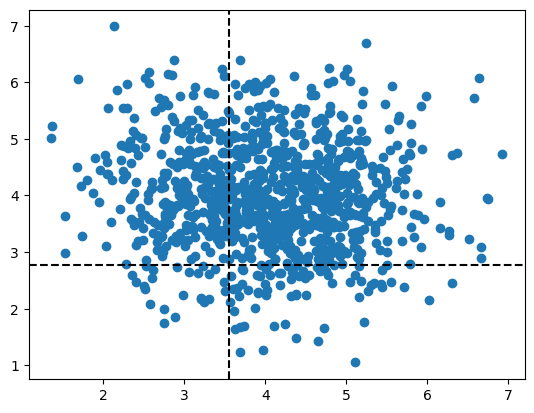

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(pred[:,0], pred[:, 1])
ax.axvline(true[0, 0], color = "black", linestyle = "--")
ax.axhline(true[0, 1], color = "black", linestyle = "--")


### T-dist check

In [6]:
from scipy import stats

dist = stats.multivariate_t(df=3, loc=[4 ,4, 4],shape= [[1, 0, 0], [0, 1, 0], [0, 0, 1]])
samples = dist.rvs(20)

print(samples)

coordinates = cdf_coordinates(samples, 10)[0]
print(coordinates)

unsorted_densities = get_orthant_density(coordinates, stats.multivariate_t(df = 3, loc=[4 ,4, 4], shape=[[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
print(unsorted_densities)

densities = sort_orthants(unsorted_densities)

print(densities.sum())

[[2.90307404 3.5881183  4.59425252]
 [4.38731003 3.76060149 4.20373083]
 [4.34420835 3.15375641 2.53069391]
 [5.8892699  4.89344459 3.9250967 ]
 [3.89424629 5.97449509 3.03622446]
 [4.97629894 4.11360156 1.88666673]
 [4.12634695 1.73405339 5.47463778]
 [4.49348494 3.41046131 3.61670607]
 [4.96072244 4.48439986 3.91477843]
 [2.67090283 3.55634124 3.85248574]
 [3.80608729 1.48951936 3.93125255]
 [3.1608453  3.68664626 5.04800455]
 [4.7593538  3.71424655 3.14654217]
 [4.38232897 2.39539296 3.96702313]
 [3.82608161 4.74334743 4.41551234]
 [3.37487348 3.30127569 0.64592452]
 [2.38240615 4.06622102 1.85672079]
 [1.1919387  4.92316047 5.76738116]
 [5.11493605 5.35059661 4.8074056 ]
 [2.64649285 2.68567755 2.62032033]]
[(2.9030740436125306, 3.5881183034333026, 4.594252522777103), (2.9030740436125306, 3.5881183034333026, 10), (2.9030740436125306, 10, 4.594252522777103), (2.9030740436125306, 10, 10), (10, 3.5881183034333026, 4.594252522777103), (10, 3.5881183034333026, 10), (10, 10, 4.5942525227

# KL Testing

In [45]:
def _generate_array(start, end, n):
    # Generate an array with values from start to end with decreasing intervals
    d = start.shape[0]

    limits = np.column_stack((start, end))
    axes = []

    for i in range(d):
        arr = np.cumsum(np.exp(-np.linspace(0, 5, n)))
        axes.append((arr - arr[0]) / (arr[-1] - arr[0]) * (limits[i, 1] - limits[i, 0]) + limits[i, 0])

    return [np.array(x) for x in list(zip(*axes))]

In [46]:
_generate_array(np.array([1, 2]), np.array([4, 5]), 2)

[array([1., 2.]), array([4., 5.])]

In [36]:
_generate_array(np.array([1, 2]), np.array([4, 5]), 2)

[array(1.), array(4.)]

In [49]:
x = stats.multivariate_normal([0.5, 4.5], [[1,0], [0,1]]).pdf(_generate_array(np.array([1, 2]), np.array([4, 5]), 10)).reshape(-1, 1)

h = np.diff(_generate_array(np.array([1, 2]), np.array([4, 5]), 10), axis = 0)

y = np.hstack((h, x[1:]))

np.prod(y, axis = 1)

array([2.55987309e-02, 3.19380703e-03, 3.68164463e-04, 5.64402275e-05,
       1.13611419e-05, 2.77125222e-06, 7.63683254e-07, 2.26587140e-07,
       7.02297076e-08])

In [163]:
test = np.array([[1, 2., 3.], [4., 5., 6.]])

np.dstack(np.meshgrid(*test))

array([[[1., 4.],
        [2., 4.],
        [3., 4.]],

       [[1., 5.],
        [2., 5.],
        [3., 5.]],

       [[1., 6.],
        [2., 6.],
        [3., 6.]]])

In [185]:
t1, t2, t3 = np.array([1, 4]), np.array([2, 5.]), torch.Tensor([3, 6.])

In [186]:
torch.cartesian_prod(torch.Tensor(t1), torch.Tensor(t2), t3)

tensor([[1., 2., 3.],
        [1., 2., 6.],
        [1., 5., 3.],
        [1., 5., 6.],
        [4., 2., 3.],
        [4., 2., 6.],
        [4., 5., 3.],
        [4., 5., 6.]])

# Problem generation

## Guarantee invertible covariance matrix

In [50]:
import numpy as np

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

def generate_covariance(d):
    # Generate a random 3x3 matrix
    A = rng.uniform(low = 1, high = 2, size = (d, d))

    # Create a covariance matrix by multiplying the matrix by its transpose
    cov_matrix = np.dot(A, A.T)

    # Ensure the matrix is invertible by adding a small value to the diagonal elements if necessary
    cov_matrix += np.eye(d) * 1e-3

    cov_matrix = cov_matrix.round(4)

    # Convert the matrix to a list
    cov_matrix_list = cov_matrix.tolist()
    return cov_matrix_list

def generate_mean(d):
    return rng.uniform(5, 15.0, d).round(0).tolist()

In [37]:
np.eye(5).tolist()

[[1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0]]

In [52]:
generate_mean(2)

[14.0, 12.0]

In [39]:
generate_covariance(2)

[[7.0057, 5.5154], [5.5154, 4.4637]]

# Problem 1

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from whats_your_bench.problem_set import Problem1
from scipy import stats
p1 = Problem1()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sample: 100%|██████████| 1200/1200 [00:01, 858.15it/s, step size=9.99e-01, acc. prob=0.920]
13:03:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:03:17 - cmdstanpy - INFO - CmdStan done processing.


In [5]:
p1.evaluate_models(stats.norm)
p1.results

,Language,Model Exe Time,KS Distance,KS Score,KS Exe Time,KL Divergence,KL Exe Time
0,pymc_model,3.156107,0.270986,0.718330,0.060314,0.186295,0.000824
1,pyro_model,1.406206,0.305629,0.378161,0.033737,0.183643,0.000336
2,stan_model,0.749451,0.220447,0.947632,0.028131,0.186233,0.000302


# Problem 2

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from whats_your_bench.problem_set import Problem2
from scipy import stats

p2 = Problem2()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sample: 100%|██████████| 1200/1200 [00:05, 233.77it/s, step size=6.49e-01, acc. prob=0.940]
13:03:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:03:37 - cmdstanpy - INFO - CmdStan done processing.


In [8]:
p2.models

namespace(pymc_model=namespace(df=1.4746847701442762,
                               loc=3,
                               scale=0.7128480476951388),
          pyro_model=namespace(df=1.4449402, loc=3, scale=0.71239096),
          stan_model=namespace(df=1.473706463,
                               loc=3,
                               scale=0.7063657529749999))

In [9]:
p2.evaluate_models(stats.t)

In [10]:
p2.results

,Language,Model Exe Time,KS Distance,KS Score,KS Exe Time,KL Divergence,KL Exe Time
0,pymc_model,3.645175,0.150952,0.999999,0.283836,0.291139,0.002671
1,pyro_model,5.137851,0.279825,0.699390,0.033960,0.293691,0.000586
2,stan_model,0.565614,0.114272,1.000000,0.027972,0.294993,0.000544


# Problem 3

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from whats_your_bench.problem_set import Problem3
from scipy import stats

p3 = Problem3()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:03, 327.11it/s, step size=8.55e-01, acc. prob=0.906]
13:05:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:05:38 - cmdstanpy - INFO - CmdStan done processing.


In [12]:
p3.evaluate_models(stats.multivariate_normal)

In [13]:
p3.results

,Language,Model Exe Time,KS Distance,KS Score,KS Exe Time,KL Divergence,KL Exe Time
0,pymc_model,4.097628,0.22432,0.995996,0.271920,0.009848,0.000725
1,pyro_model,3.672365,0.23787,0.994853,0.067097,0.009293,0.000377
2,stan_model,1.618848,0.20991,0.994961,0.057479,0.009775,0.000244


# Problem 4

In [14]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from whats_your_bench.problem_set import Problem4
from scipy import stats

p4 = Problem4()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, chol]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:12, 95.36it/s, step size=7.19e-01, acc. prob=0.920] 
13:06:45 - cmdstanpy - INFO - compiling stan file /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean.stan to exe file /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean
13:07:00 - cmdstanpy - INFO - compiled model executable: /Users/PatrickPagni/repositories/whats_your_bench/whats_your_bench/stan_models/mvNormalKnownMean
13:07:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:07:02 - cmdstanpy - INFO - CmdStan done processing.
13:07:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception:

In [15]:
p4.evaluate_models(stats.multivariate_t)

In [16]:
p4.results

,Language,Model Exe Time,KS Distance,KS Score,KS Exe Time,KL Divergence,KL Exe Time
0,pymc_model,16.447134,0.334638,0.572848,0.699354,2.304311,0.000465
1,pyro_model,12.591551,0.325744,0.489919,0.658936,2.335316,0.000207
2,stan_model,17.559383,0.439740,0.070895,0.673437,2.304622,0.000195


# Pipeline tools

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from whats_your_bench import problem_set
import inspect
import pandas as pd

classes = [cls_obj for cls_name, cls_obj in inspect.getmembers(sys.modules['whats_your_bench.problem_set']) if inspect.isclass(cls_obj)][1:]

results = pd.DataFrame()

for i, problem in enumerate(classes):
    p = problem()
    p.run_models()
    success = False
    retries = 0

    while not success:
        try:
            p.evaluate_models()
            success = True
        except:
            if retries < 3:
                retries += 1
            else:
                print(i)
                print(p.models)
                raise RuntimeError

    p.results.insert(loc = 0, column = "Problem #", value = [i+1]*p.results.shape[0])
    results = pd.concat([results, p.results], axis = 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sample: 100%|██████████| 1200/1200 [00:01, 827.37it/s, step size=9.19e-01, acc. prob=0.930]
16:34:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:29 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sample: 100%|██████████| 1200/1200 [00:01, 910.84it/s, step size=8.50e-01, acc. prob=0.937]
16:34:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:36 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sample: 100%|██████████| 1200/1200 [00:01, 1001.39it/s, step size=1.93e+00, acc. prob=0.914]
16:34:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:41 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sample: 100%|██████████| 1200/1200 [00:04, 274.29it/s, step size=6.90e-01, acc. prob=0.922]
16:34:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:34:51 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sample: 100%|██████████| 1200/1200 [00:04, 294.78it/s, step size=8.53e-01, acc. prob=0.929]
16:35:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:01 - cmdstanpy - INFO - CmdStan done processing.
16:35:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Degrees of freedom parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Consider re-running with show_console=True if the above output is unclear!


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sample: 100%|██████████| 1200/1200 [00:03, 314.49it/s, step size=8.58e-01, acc. prob=0.893]
16:35:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:10 - cmdstanpy - INFO - CmdStan done processing.
16:35:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: student_t_lpdf: Degrees of freedom parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is inf, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Exception: student_t_lpdf: Degrees of freedom parameter is 0, but must be positive finite! (in 'normalKnownMean.stan', line 17, column 4 to column 39)
Consider re-running with show_console=True if the above output is unclear!


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:03, 360.89it/s, step size=1.01e+00, acc. prob=0.915]
16:35:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:20 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:03, 373.41it/s, step size=8.37e-01, acc. prob=0.915]
16:35:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:34 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:03, 312.81it/s, step size=6.78e-01, acc. prob=0.938]
16:35:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:35:46 - cmdstanpy - INFO - CmdStan done processing.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, chol]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:10, 119.60it/s, step size=7.85e-01, acc. prob=0.893]
16:36:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:36:15 - cmdstanpy - INFO - CmdStan done processing.
16:36:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Consider re-r

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, chol]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:12, 98.96it/s, step size=5.63e-01, acc. prob=0.941] 
16:36:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:36:54 - cmdstanpy - INFO - CmdStan done processing.
16:36:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, chol]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sample: 100%|██████████| 1200/1200 [00:11, 108.66it/s, step size=7.69e-01, acc. prob=0.913]
16:37:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:37:37 - cmdstanpy - INFO - CmdStan done processing.
16:37:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'mvNormalKnownMean.stan', line 25, column 4 to column 37)
	Exception: 

In [3]:
results.reset_index(drop=True)

,Problem #,Language,Model Exe Time,KS Distance,KS Score,KS Exe Time,KL Divergence,KL Exe Time
0,1,pymc_model,3.076214,0.105533,1.000000,0.583605,0.189998,0.001578
1,1,pyro_model,1.469022,0.156757,0.965072,0.728058,0.181221,0.000356
2,1,stan_model,0.878592,0.162319,0.888771,0.766096,0.196044,0.000299
3,2,pymc_model,2.022478,0.149866,0.991016,0.759518,0.045807,0.000515
4,2,pyro_model,1.320645,0.116147,1.000000,0.568217,0.042613,0.000306
5,2,stan_model,0.533901,0.092272,1.000000,0.655101,0.043420,0.000333
6,3,pymc_model,2.069734,0.043118,1.000000,0.331404,0.025588,0.000539
7,3,pyro_model,1.201544,0.066125,1.000000,0.360424,0.023861,0.000359
8,3,stan_model,0.489387,0.170397,0.713483,0.870562,0.024330,0.000378
9,4,pymc_model,3.466220,0.078301,1.000000,0.576982,0.231842,0.001807


# Archive

### PyMC

In [4]:
p1._pymc_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
p1._model_dist(stats.norm, p1.pymc_params)

### Pyro

In [5]:
p1._pyro_model()

Sample: 100%|██████████| 1200/1200 [00:01, 723.38it/s, step size=1.07e+00, acc. prob=0.937]


In [7]:
p1._model_dist(stats.norm, p1.pyro_params)

### Stan

In [6]:
p1._stan_model()

15:31:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:31:20 - cmdstanpy - INFO - CmdStan done processing.


In [11]:
p1._model_dist(stats.norm, p1.stan_params)